In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Load the training data
col_names = ['A', 'B', 'deltaI', 'deltaR', 'E', 'k']
peak_names = ['peak1', 'peak2', 'peak3', 'peak4', 'peak5']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4', 'loc5']
width_names = ['width1', 'width2', 'width3','width4', 'width5']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4', 'prom5']
col_names = col_names + peak_names + locs_names + width_names + prom_names

data = pd.read_csv('Training_Data/Line_Cut/LineCutTrainingData052118_fixedfit.csv', header = None, names = col_names)

#The peak information columns have zeros when there weren't 5 peaks

data.head()

,A,B,deltaI,deltaR,E,k,peak1,peak2,peak3,peak4,...,width1,width2,width3,width4,width5,prom1,prom2,prom3,prom4,prom5
0,-0.38805,-0.22596,0.81472,-0.14798,-0.4,0.06469,0.99666,0.31311,0.19045,0.17845,...,1.4630,46.800,50.281,32.218,0.000,1.27010,0.53509,0.37420,0.15110,0.00000
1,-0.33357,-0.16418,0.81472,-0.14798,-0.3,0.12292,0.82062,0.25860,0.15841,0.13729,...,1.5461,24.827,26.035,27.184,26.446,1.28980,0.45609,0.30073,0.26413,0.20762
2,-0.30657,-0.15064,0.81472,-0.14798,-0.2,0.16228,0.71396,0.23300,0.14533,0.12049,...,1.4174,18.767,19.882,20.103,20.188,1.12150,0.41003,0.27792,0.22411,0.18490
3,-0.28211,-0.14453,0.81472,-0.14798,-0.1,0.19463,0.62981,0.21673,0.13800,0.10512,...,1.3712,15.619,16.632,16.654,17.221,0.99603,0.37978,0.26048,0.20270,0.18805
4,-0.26310,-0.13547,0.81472,-0.14798,0.0,0.22312,0.55621,0.20383,0.13048,0.10268,...,1.3342,13.635,14.398,14.818,14.560,0.87763,0.35828,0.24145,0.19974,0.16361


## Creating the various test, train, data sets

In [3]:
target = data[['deltaI', 'deltaR']]

train1 = data[['A', 'B', 'E', 'k']]
train2 = data[['A', 'B', 'E']]

##Just the entries with E = -0.4
#train_E_04 = train1[train1['E']==-0.4]
#target_E_04 = target[train1['E']==-0.4]
#train_E_04_a = train_E_04[['A', 'B']] 

#Making a copy of the data frame
df1 = data

columns1 = df1.columns
X1 = df1.drop(columns1[2:4], axis = 1) #everything except target
X2 = X1.drop(columns1[6:], axis = 1) # no additional peak info
X3 = X2.drop(columns1[4:6], axis = 1) # no E, k

Y1 = df1[['deltaR']]
Y2 = df1[['deltaI']]
Y3 = pd.DataFrame.join(Y1,Y2)

#Making another copy of the data frame
df2 = df1

n1 = int(len(df1['deltaR'])/9)

#Initializing a new dataframe to use the average peaks, prominences and widths as features instead of each one
new_df = pd.DataFrame(np.zeros([n1,7]), columns = ['deltaI', 'deltaR', 'avgA', 'avgB', 'avgPeak', 'avgWidth', 'avgProm'])
for i in range(1,n1+1):
        
        temp_df = df2[9*(i-1):9*i]
        columns = temp_df.columns
        new_df['deltaI'][i-1] = temp_df['deltaI'].mean()
        new_df['deltaR'][i-1] = temp_df['deltaR'].mean()
        
        new_df['avgA'][i-1] = temp_df['A'].mean()
        new_df['avgB'][i-1] = temp_df['B'].mean()
        
        new_df['avgPeak'][i-1] = temp_df[columns[6:11]][temp_df[columns[6:11]]>0].mean().mean()
        
        new_df['avgWidth'][i-1] = temp_df[columns[11:16]][temp_df[columns[11:16]]>0].mean().mean()
        
        new_df['avgProm'][i-1] = temp_df[columns[16:21]][temp_df[columns[16:21]]>0].mean().mean()
        
        
#new_df.head()
new_columns = new_df.columns
X_new_df = new_df.drop(new_columns[0:2], axis=1)
Y_new_df = new_df.drop(new_columns[2:], axis = 1)


In [4]:
def myResiduals(testY, predictY):
    ## residuals 1 
    i = 0 # resetting i 
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
        ys = testY # get ys of testing data 
        ys = ys.values # take out indexing, data types, names
        y = ys[i]
        predict_ys = predictY # get ys of all dots/points
        predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
        diff = y - predict_y # find the difference in height 
        diff = abs(diff) # take the absolute value 
        residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
    residual_average = residual_sum/iterations # find the average of the residuals 
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals 

    minY = min(ys) # find the minimum y value for testing data 
    maxY = max(ys) # find the max y value for testing data 
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data 
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions 
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range 
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
def myResiduals_values(testY, predictY):
    ## residuals 1 
    i = 0 # resetting i 
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
        ys = testY # get ys of testing data 
        ys = ys.values # take out indexing, data types, names
        y = ys[i]
        predict_ys = predictY # get ys of all dots/points
        predict_ys = predict_ys.values
        predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
        diff = y - predict_y # find the difference in height 
        diff = abs(diff) # take the absolute value 
        residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
    residual_average = residual_sum/iterations # find the average of the residuals 
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals 

    minY = min(ys) # find the minimum y value for testing data 
    maxY = max(ys) # find the max y value for testing data 
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data 
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions 
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range 
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
def myResiduals_index(testY, predictY):
    ## residuals 1 
    i = 0 # resetting i 
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
        ys = testY # get ys of testing data 
        ys = ys.values # take out indexing, data types, names
        y = ys[i]
        predict_ys = predictY # get ys of all dots/points
        predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
        diff = y - predict_y # find the difference in height 
        diff = abs(diff) # take the absolute value 
        residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
    residual_average = residual_sum/iterations # find the average of the residuals 
    print('The average residual for predict:', round(residual_average[0],4)) # display average of residuals 

    minY = min(ys) # find the minimum y value for testing data 
    maxY = max(ys) # find the max y value for testing data 
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data 
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions 
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average[0]/abs(rangepredict))*100 # calculate what percent the residual is of the range 
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
def myResiduals_index_values(testY, predictY):
    ## residuals 1 
    i = 0 # resetting i 
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
        ys = testY # get ys of testing data 
        ys = ys.values # take out indexing, data types, names
        y = ys[i]
        predict_ys = predictY # get ys of all dots/points
        predict_ys = predict_ys.values
        predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
        diff = y - predict_y # find the difference in height 
        diff = abs(diff) # take the absolute value 
        residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
    residual_average = residual_sum/iterations # find the average of the residuals 
    print('The average residual for predict:', round(residual_average[0],4)) # display average of residuals 

    minY = min(ys) # find the minimum y value for testing data 
    maxY = max(ys) # find the max y value for testing data 
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data 
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions 
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average[0]/abs(rangepredict))*100 # calculate what percent the residual is of the range 
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
def myRsquared(test, predict, printing):
    r2score = round(r2_score(test,predict),4)
    if printing == 1:
        print('R squared Score:' ,  r2score) #calculate and display the r squared score
    
def myplot(xTest, yTest, predictions, xlabel, ylabel):
    ax.plot(xTest,yTest, 'ko', alpha = 0.5)
    ax.plot(xTest, predictions,'bo')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def plotAgainst(testing, predictions):
    ax.plot(testing,predictions, 'go')
    xmin,xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
    yMin = min(predictions)
    yMax = max(predictions)
    ax.set_xlim(xmin-0.5,xmax+0.5)
    ax.set_ylim(yMin-0.2, yMax+0.2)
    plt.xlabel('Testing Data')
    plt.ylabel('Predictions')
    plt.margins(0.5,1)
    plt.tight_layout()
    
def myplot2(xTesting,yTesting, xPredictions, yPredictions):
    ax.plot(xTesting, yTesting, "ko", label="Testing") # plot the testing data black 
    ax.plot(xPredictions, yPredictions, "bo", label="predictions", alpha = 0.8) # plot the prediction data blue 
    plt.xlabel('Delta R')
    plt.ylabel('Delta I')
    pylab.legend(loc='upper right')
def plotAgainst2(testing, predictions):
    ax.plot(testing, predictions,'go') # plot the testing versus predictions in green 
    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
    plt.xlabel('Testing Data')
    plt.ylabel('Predictions')
    plt.margins(0.5,1)
    ax.set_xlim(xmin-0.5,xmax+0.5)
    ax.set_ylim(xmin-0.25,xmax+0.05)

#### Splitting each dataset in the previous cell into train and test

In [5]:
#Random state
rs = 42
#Test size
ts1 = 0.3

X_a_train, X_a_test, Y_a_train, Y_a_test = train_test_split(train1, target, test_size = ts1, random_state = rs)

X_b_train, X_b_test, Y_b_train, Y_b_test = train_test_split(train2, target, test_size = ts1, random_state = rs)

#Splitting X1, Y1 into train and test
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs)

#Splitting X2, Y2 into train and test
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs)

#Splitting X3, Y3 into train and test
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size = ts1, random_state = rs)

#Splitting X_new_df, Y_new_df into train and test
X_new_train, X_new_test, Y_new_train, Y_new_test = train_test_split(X_new_df, Y_new_df, test_size = ts1, random_state = rs)



## Making models

#### Using linear regression from scikit-learn on the minimal data set (only A, B, E, k as features)

Mean squared error: 0.07
 
The average residual for predict: 0.2183
Residual is this percent of predict range 8.958 %
 
The average residual for predict: 0.1902
Residual is this percent of predict range 16.142 %
R squared Score: 0.4669


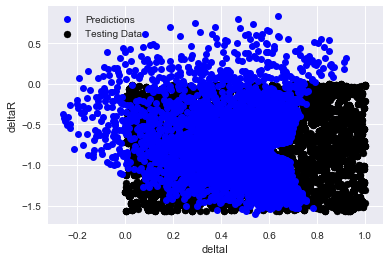

In [6]:
import pylab
#Initialize and fit model to training data
reg = linear_model.LinearRegression()
reg1 = reg.fit(X_a_train, Y_a_train)

#Make predictions using the testing set
y_pred1 = reg1.predict(X_a_test)

# The coefficients
# print('Coefficients: \n', reg1.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_a_test, y_pred1))
# Plot outputs
plt.scatter(Y_a_test['deltaI'], Y_a_test['deltaR'],  color=['black'], label = 'Testing Data')
plt.plot(y_pred1[:,0], y_pred1[:,1], 'bo', label = 'Predictions')

# add labels to figure
plt.xlabel('deltaI')
plt.ylabel('deltaR')
pylab.legend(loc='upper left')

########################################### RESIDUALS AND R SQUARED ############################################## 
print(' ')
myResiduals(Y_a_test['deltaR'], y_pred1[:,1])
print(' ')
myResiduals(Y_a_test['deltaI'], y_pred1[:,0])
myRsquared(Y_a_test, y_pred1, 1)

#### Using linear regression from scikit-learn on the data set with only A, B and E as features (no k). 

Mean squared error: 0.07
 
The average residual for predict: 0.2186
Residual is this percent of predict range 8.971 %
 
The average residual for predict: 0.1921
Residual is this percent of predict range 16.245 %
R squared Score: 0.4559


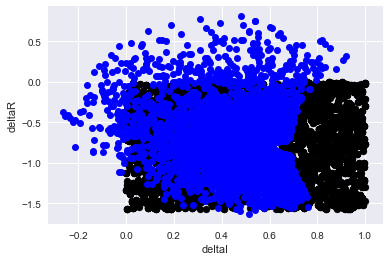

In [7]:
#Initialize and fit model to training data
reg = linear_model.LinearRegression()
reg2 = reg.fit(X_b_train, Y_b_train)

#Make predictions using the testing set
y_pred2 = reg2.predict(X_b_test)

# The coefficients
# print('Coefficients: \n', reg2.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_b_test, y_pred2))

# Plot outputs
plt.scatter(Y_b_test['deltaI'], Y_b_test['deltaR'],  color=['black'])
plt.plot(y_pred2[:,0], y_pred2[:,1], 'bo')

# add labels to figure
plt.xlabel('deltaI')
plt.ylabel('deltaR')

########################################### RESIDUALS AND R SQUARED ############################################## 
print(' ')
myResiduals(Y_b_test['deltaR'], y_pred2[:,1])
print(' ')
myResiduals(Y_b_test['deltaI'], y_pred2[:,0])
myRsquared(Y_b_test, y_pred2, 1)

Mean squared error: 0.04
 
The average residual for predict: 0.1382
Residual is this percent of predict range 13.566 %
 
The average residual for predict: 0.1505
Residual is this percent of predict range 5.975 %
R squared Score: 0.7134


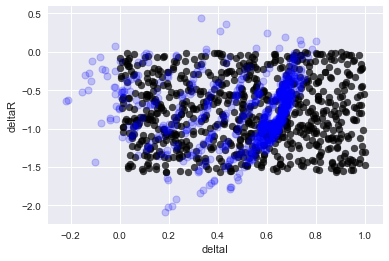

In [8]:
# new = using averages of columns 
#Initialize and fit model to training data with new columns
reg = linear_model.LinearRegression()
reg_new_lm = reg.fit(X_new_train, Y_new_train)

#Make predictions using the testing set
y_pred_new_lm = reg_new_lm.predict(X_new_test)

# The coefficients
# print('Coefficients: \n', reg_new_lm.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_new_test, y_pred_new_lm))
# Plot outputs
plt.scatter(Y_new_test['deltaI'], Y_new_test['deltaR'],  color=['black'], alpha = 0.7)
plt.scatter(y_pred_new_lm[:,0], y_pred_new_lm[:,1], color='blue', linewidth=1, alpha = 0.2)
# add labels to figure
plt.xlabel('deltaI')
plt.ylabel('deltaR')
########################################### RESIDUALS AND R SQUARED ############################################## 
print(' ')
myResiduals(Y_new_test['deltaI'], y_pred_new_lm[:,0])
print(' ')
myResiduals(Y_new_test['deltaR'], y_pred_new_lm[:,1])
myRsquared(Y_new_test, y_pred_new_lm, 1)

# Using statsmodels

In [9]:
#Initialize and fit OLS model for deltaR 
model = sm.OLS(Y1_train, X1_train)
results = model.fit()

#Make predictions on testing data
predictions = results.predict(X1_test) # make the predictions by the model

# results.summary()

The average residual for predict: 0.1594
Residual is this percent of predict range 5.054 %
R squared Score: 0.7811


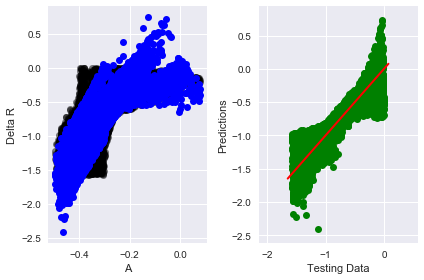

In [10]:
#### PLOTTING ####
import pylab 

ax = pylab.subplot(121)
myplot(X1_test['A'], Y1_test, predictions, 'A', 'Delta R')

ax = pylab.subplot(122)
plotAgainst(Y1_test,predictions)

###### RESIDUALS AND R SQUARED ######
myResiduals_index_values(Y1_test, predictions)
myRsquared(Y1_test, predictions, 1)

In [11]:
#Initialize and fit OLS model for deltaI 
model_I = sm.OLS(Y2_train, X1_train)
results_I = model_I.fit()

#Make predictions on testing data
predictions_I = results_I.predict(X1_test) # make the predictions by the model

# results_I.summary()

The average residual for predict: 0.1559
Residual is this percent of predict range 5.102 %
R squared Score: 0.5481


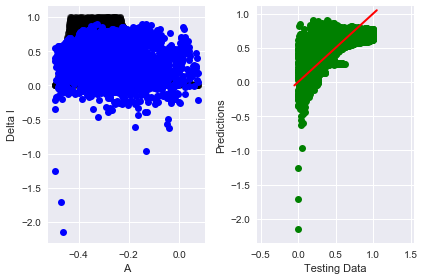

In [12]:
#### PLOTTING ####
import pylab 

ax = pylab.subplot(121)
myplot(X1_test['A'], Y2_test, predictions_I, 'A', 'Delta I')

ax = pylab.subplot(122)
plotAgainst(Y2_test,predictions_I)

####### RESIDUALS AND R SQUARED #######
myResiduals_index_values(Y2_test, predictions_I)
myRsquared(Y2_test, predictions_I, 1)


In [13]:
#Initialize and fit model for just deltaR using A, phi, E, k only
model2 = sm.OLS(Y1_train,X2_train)
results2 = model2.fit()

predictions2 = results2.predict(X2_test)
#  results2.summary()

The average residual for predict: 0.2195
Residual is this percent of predict range 9.175 %
R squared Score: 0.6034


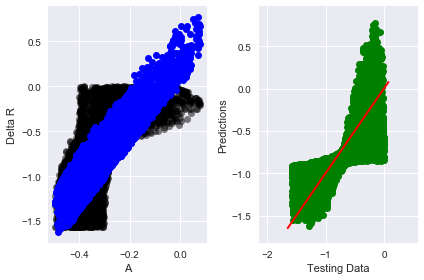

In [14]:
#### PLOTTING ####
import pylab 

ax = pylab.subplot(121)
myplot(X2_test['A'], Y1_test, predictions2, 'A', 'Delta R')

ax = pylab.subplot(122)
plotAgainst(Y1_test,predictions2)

####### RESIDUALS AND R SQUARED #######
myResiduals_index_values(Y1_test, predictions2)
myRsquared(Y1_test, predictions2, 1)


In [15]:
#Initialize and fit model for just deltaI using A, phi, E, k only
model2_I = sm.OLS(Y2_train,X2_train)
results2_I = model2_I.fit()

predictions2_I = results2_I.predict(X2_test)
# results2_I.summary()

The average residual for predict: 0.2043
Residual is this percent of predict range 19.749 %
R squared Score: 0.2281


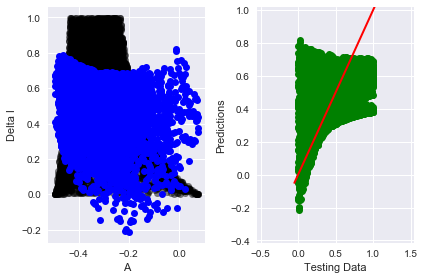

In [16]:
#### PLOTTING ####
import pylab 

ax = pylab.subplot(121)
myplot(X2_test['A'], Y2_test, predictions2_I, 'A', 'Delta I')

ax = pylab.subplot(122)
plotAgainst(Y2_test,predictions2_I)

####### RESIDUALS AND R SQUARED #######
myResiduals_index_values(Y2_test, predictions2_I)
myRsquared(Y2_test, predictions2_I, 1)

In [17]:
#Initialize and fit model for just deltaR using A, phi only
model3 = sm.OLS(Y1_train,X3_train)
results3 = model3.fit()

predictions3 = results3.predict(X3_test)
# results3.summary()

The average residual for predict: 0.2441
Residual is this percent of predict range 12.69 %
R squared Score: 0.5286


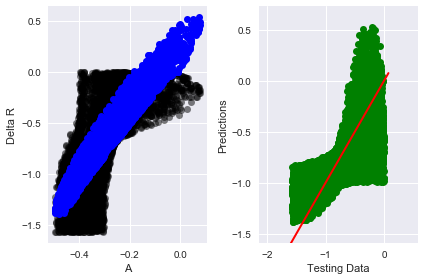

In [18]:
#### PLOTTING ####
import pylab 

ax = pylab.subplot(121)
myplot(X3_test['A'], Y1_test, predictions3, 'A', 'Delta R')

ax = pylab.subplot(122)
plotAgainst(Y1_test,predictions3)

###### RESIDUALS AND R SQUARED ######
myResiduals_index_values(Y1_test, predictions3)
myRsquared(Y1_test, predictions3, 1)

In [19]:
#Initialize and fit model for just deltaI using A, phi only
model3_I = sm.OLS(Y2_train,X3_train)
results3_I = model3_I.fit()

predictions3_I = results3_I.predict(X3_test)
# results3_I.summary()

The average residual for predict: 0.2711
Residual is this percent of predict range 28.451 %
R squared Score: -0.2459


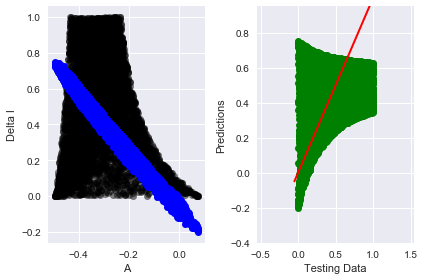

In [20]:
#### PLOTTING ####
import pylab 

ax = pylab.subplot(121)
myplot(X3_test['A'], Y2_test, predictions3_I, 'A', 'Delta I')

ax = pylab.subplot(122)
plotAgainst(Y2_test,predictions3_I)

######RESIDUALS AND R SQUARED ######
myResiduals_index_values(Y2_test, predictions3_I)
myRsquared(Y2_test, predictions3_I, 1)

In [21]:
#Initialize and fit model for just deltaI using newer dataframe with average peak info
model_new1_I = sm.OLS(Y_new_train['deltaI'],X_new_train)
results_new1_I = model_new1_I.fit()

predictions_new1_I = results_new1_I.predict(X_new_test)
# results_new1_I.summary()

The average residual for predict: 0.1386
Residual is this percent of predict range 13.628 %
R squared Score: 0.6372


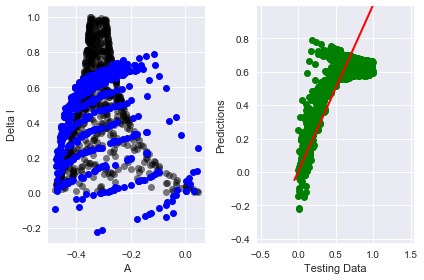

In [22]:
#### PLOTTING ####
import pylab 

ax = pylab.subplot(121)
myplot(X_new_test['avgA'], Y_new_test['deltaI'], predictions_new1_I, 'A', 'Delta I')

ax = pylab.subplot(122)
plotAgainst(Y_new_test['deltaI'],predictions_new1_I)

###### RESIDUALS AND R SQUARED #######
myResiduals_values(Y_new_test['deltaI'], predictions_new1_I)
myRsquared(Y_new_test['deltaI'], predictions_new1_I, 1)


In [23]:
#Initialize and fit model for just deltaR using newer dataframe with average peak info
model_new1 = sm.OLS(Y_new_train['deltaR'],X_new_train)
results_new1 = model_new1.fit()

predictions_new1 = results_new1.predict(X_new_test)
# results_new1.summary2()


The average residual for predict: 0.1709
Residual is this percent of predict range 7.2 %
R squared Score: 0.7518


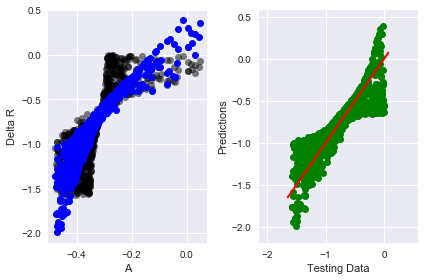

In [24]:
#### PLOTTING ####
import pylab 

ax = pylab.subplot(121)
myplot(X_new_test['avgA'], Y_new_test['deltaR'], predictions_new1, 'A', 'Delta R')

ax = pylab.subplot(122)
plotAgainst(Y_new_test['deltaR'],predictions_new1)

######## RESIDUALS AND R SQUARED #######
myResiduals_values(Y_new_test['deltaR'], predictions_new1)
myRsquared(Y_new_test['deltaR'], predictions_new1, 1)

#### Using statsmodels GLM (generalized linear model)

In [25]:
model4 = sm.GLM(Y1_train,X1_train)
results4 = model4.fit()
predictions4 = results4.predict(X1_test)

# results4.summary2()

The average residual for predict: 0.1594
Residual is this percent of predict range 5.054 %
R squared Score: 0.7811


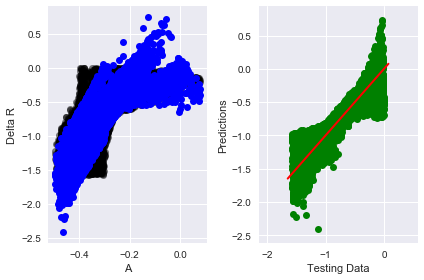

In [26]:
#### PLOTTING ####
import pylab 

ax = pylab.subplot(121)
myplot(X1_test['A'], Y1_test, predictions4, 'A', 'Delta R')

ax = pylab.subplot(122)
plotAgainst(Y1_test, predictions4)

###### RESIDUALS AND R SQUARED #####
myResiduals_index_values(Y1_test, predictions4)
myRsquared(Y1_test , predictions4, 1)

The average residual for predict: 0.1559
Residual is this percent of predict range 5.102 %
R squared Score: 0.5481


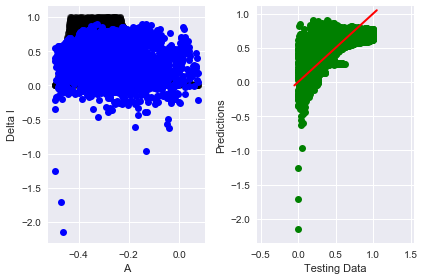

In [27]:
model4_I = sm.GLM(Y2_train,X1_train)
results4_I = model4_I.fit()
predictions4_I = results4_I.predict(X1_test)

# results4_I.summary2()

#### PLOTTING ####
import pylab 

ax = pylab.subplot(121)
myplot(X1_test['A'], Y2_test, predictions4_I, 'A', 'Delta I')

ax = pylab.subplot(122)
plotAgainst(Y2_test, predictions4_I)

###### RESIDUALS AND R SQUARED #######
myResiduals_index_values(Y2_test, predictions4_I)
myRsquared(Y2_test , predictions4_I, 1)

The average residual for predict: 0.2195
Residual is this percent of predict range 9.175 %
R squared Score: 0.6034


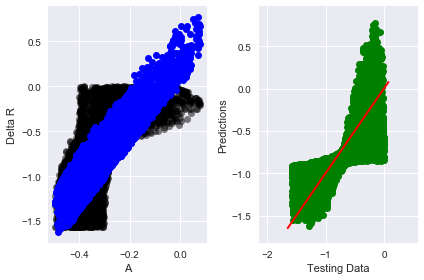

In [28]:
model5 = sm.GLM(Y1_train,X2_train)
results5 = model5.fit()
predictions5 = results5.predict(X2_test)

# results5.summary()

#### PLOTTING ####
import pylab 

ax = pylab.subplot(121)
myplot(X2_test['A'], Y1_test, predictions5, 'A', 'Delta R')

ax = pylab.subplot(122)
plotAgainst(Y1_test, predictions5)

######RESIDUALS AND R SQUARED #######
myResiduals_index_values(Y1_test, predictions5)
myRsquared(Y1_test , predictions5, 1)

The average residual for predict: 0.2043
Residual is this percent of predict range 19.749 %
R squared Score: 0.2281


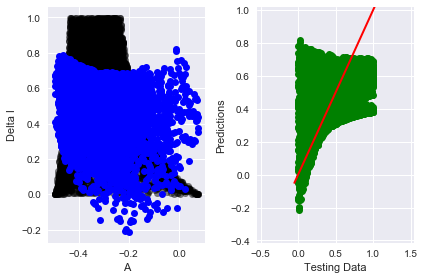

In [29]:
model5_I = sm.GLM(Y2_train,X2_train)
results5_I = model5_I.fit()
predictions5_I = results5_I.predict(X2_test)
# results5_I.summary2()

#### PLOTTING ####
import pylab 
ax = pylab.subplot(121)
myplot(X2_test['A'], Y2_test, predictions5_I, 'A', 'Delta I')

ax = pylab.subplot(122)
plotAgainst(Y2_test, predictions5_I)

##### RESIDUALS AND R SQUARED ##### 
myResiduals_index_values(Y2_test, predictions5_I)
myRsquared(Y2_test , predictions5_I, 1)

The average residual for predict: 0.2441
Residual is this percent of predict range 12.69 %
R squared Score: 0.5286


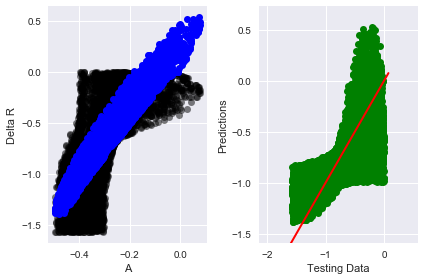

In [30]:
model6 = sm.GLM(Y1_train,X3_train)
results6 = model6.fit()
predictions6 = results6.predict(X3_test)
# results6.summary2()

#### PLOTTING ####
import pylab 
ax = pylab.subplot(121)
myplot(X3_test['A'], Y1_test, predictions6, 'A', 'Delta R')

ax = pylab.subplot(122)
plotAgainst(Y1_test, predictions6)

##### RESIDUALS AND R SQUARED #####
myResiduals_index_values(Y1_test, predictions6)
myRsquared(Y1_test , predictions6, 1)

The average residual for predict: 0.2711
Residual is this percent of predict range 28.451 %
R squared Score: -0.2459


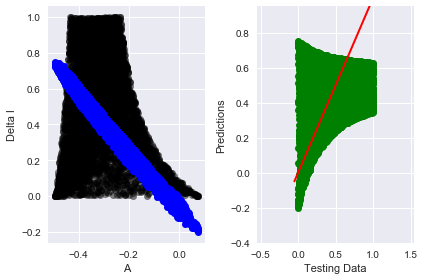

In [31]:
model6_I = sm.GLM(Y2_train,X3_train)
results6_I = model6_I.fit()
predictions6_I = results6_I.predict(X3_test)
#results6_I.summary()

#### PLOTTING ####
import pylab 
ax = pylab.subplot(121)
myplot(X3_test['A'], Y2_test, predictions6_I, 'A', 'Delta I')

ax = pylab.subplot(122)
plotAgainst(Y2_test, predictions6_I)

##### RESIDUALS AND R SQUARED #####
myResiduals_index_values(Y2_test, predictions6_I)
myRsquared(Y2_test , predictions6_I, 1)

 
The average residual for predict: 0.1709
Residual is this percent of predict range 7.2 %
R squared Score: 0.7518


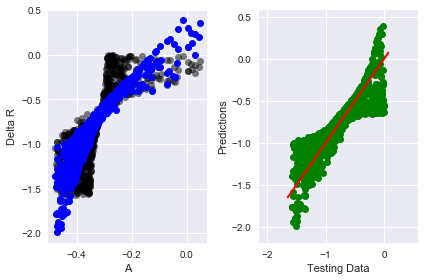

In [32]:
model_new2 = sm.GLM(Y_new_train['deltaR'],X_new_train)
results_new2 = model_new2.fit()
predictions_new2 = results_new2.predict(X_new_test)
#results_new2.summary()

#### PLOTTING ####
import pylab 
ax = pylab.subplot(121)
myplot(X_new_test['avgA'], Y_new_test['deltaR'], predictions_new2, 'A', 'Delta R')

ax = pylab.subplot(122)
plotAgainst(Y_new_test['deltaR'], predictions_new2)

###### RESIDUALS AND R SQUARED ######
print(' ')
myResiduals_values(Y_new_test['deltaR'], predictions_new2)
myRsquared(Y_new_test['deltaR'], predictions_new2, 1)

R squared Score: 0.6372


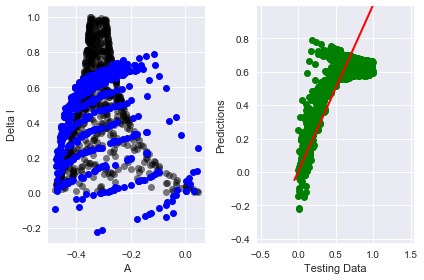

In [33]:
model_new2_I = sm.GLM(Y_new_train['deltaI'],X_new_train)
results_new2_I = model_new2_I.fit()
predictions_new2_I = results_new2_I.predict(X_new_test)
# results_new2_I.summary()

#### PLOTTING ####
import pylab 
ax = pylab.subplot(121)
myplot(X_new_test['avgA'], Y_new_test['deltaI'], predictions_new2_I, 'A', 'Delta I')

ax = pylab.subplot(122)
plotAgainst(Y_new_test['deltaI'], predictions_new2_I)

##### RESIDUALS AND R SQUARED ######
myRsquared(Y_new_test['deltaI'] , predictions_new2_I, 1)

### Using Decision Trees in scikit-learn to predict deltaI and deltaR simultaneously

 
The average residual for predict: 0.0361
Residual is this percent of predict range 3.668 %
R squared Score: 0.9798
 
The average residual for predict: 0.0208
Residual is this percent of predict range 2.087 %
R squared Score: 0.9934
 
The average residual for predict: 0.0209
Residual is this percent of predict range 2.101 %
R squared Score: 0.9933


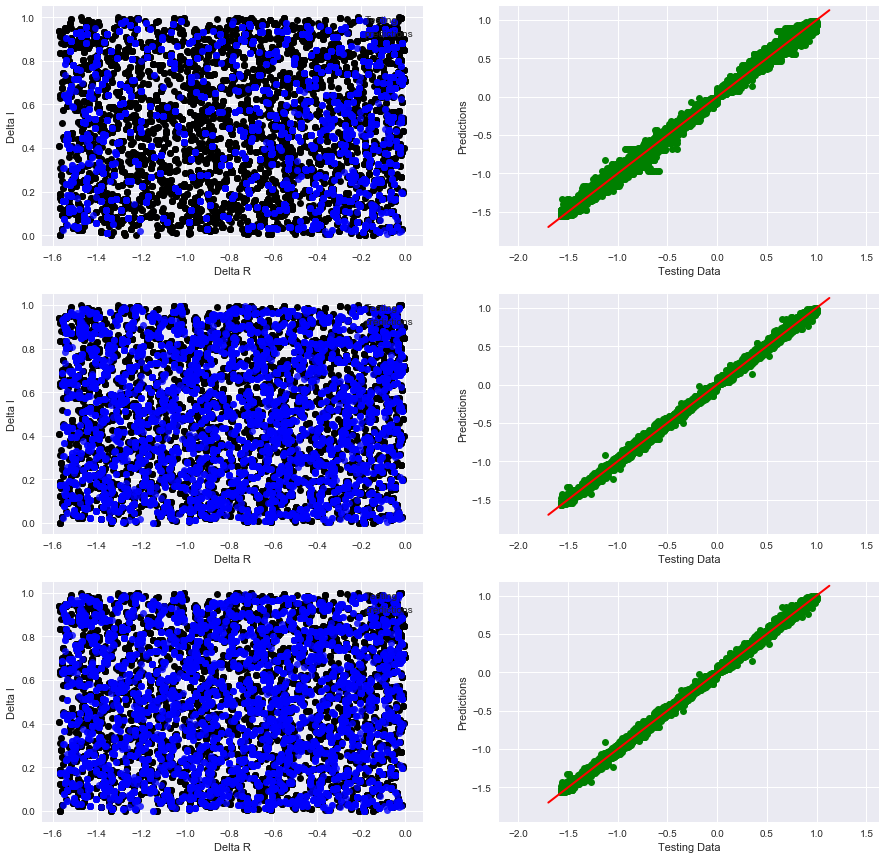

In [34]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
import pylab

#Initialize the models
regr_1 = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
regr_2 = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
regr_3 = DecisionTreeRegressor(max_depth=40, min_samples_leaf=5)

#Fit the models
regr_1.fit(X1_train, Y3_train)
regr_2.fit(X1_train, Y3_train)
regr_3.fit(X1_train, Y3_train)


#Print the coefficients or importances
#print('Regression 1 Feature Importance:', regr_1.feature_importances_)
#print('Regression 2 Feature Importance:', regr_2.feature_importances_)
#print('Regression 3 Feature Importance:', regr_3.feature_importances_)

#Use model to predict
y_1 = regr_1.predict(X1_test)
y_2 = regr_2.predict(X1_test)
y_3 = regr_3.predict(X1_test)

#Trying to understand the scoring
#print('Regression 1 Score: ', regr_1.score(X1_test,Y3_test), ', using max depth of 10')
#print('Regression 2 Score: ', regr_2.score(X1_test,Y3_test), ', using max depth of 20')
#print('Regression 3 Score: ', regr_3.score(X1_test,Y3_test),', using max depth of 30')
from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
cross_val_score(regressor, X1, Y3, cv=10)

#### PLOTTING ####     
f,(ax) = plt.subplots(figsize=(15,15))
ax = pylab.subplot(321) 
myplot2(Y3_test.iloc[:, 0], Y3_test.iloc[:, 1], y_1[:, 0], y_1[:, 1])

ax = pylab.subplot(322) 
plotAgainst2(Y3_test, y_1)

ax = pylab.subplot(323) 
myplot2(Y3_test.iloc[:, 0], Y3_test.iloc[:, 1], y_2[:, 0], y_2[:, 1])

ax = pylab.subplot(324)  
plotAgainst2(Y3_test, y_2)

ax = pylab.subplot(325) 
myplot2(Y3_test.iloc[:, 0], Y3_test.iloc[:, 1], y_3[:, 0], y_3[:, 1])

ax = pylab.subplot(326) 
plotAgainst2(Y3_test, y_3)

######RESIDUALS AND R SQUARED #####
print(' ')
myResiduals(Y3_test['deltaI'], y_1[:,1])
myRsquared(Y3_test, y_1, 1)
print(' ')
myResiduals(Y3_test['deltaI'], y_2[:,1])
myRsquared(Y3_test, y_2, 1)
print(' ')
myResiduals(Y3_test['deltaI'], y_3[:,1])
myRsquared(Y3_test, y_3, 1)

 
The average residual for predict: 0.0245
Residual is this percent of predict range 1.583 %
R squared Score: 0.9919
 
The average residual for predict: 0.024
Residual is this percent of predict range 1.553 %
R squared Score: 0.992
 
The average residual for predict: 0.0242
Residual is this percent of predict range 1.564 %
R squared Score: 0.9919


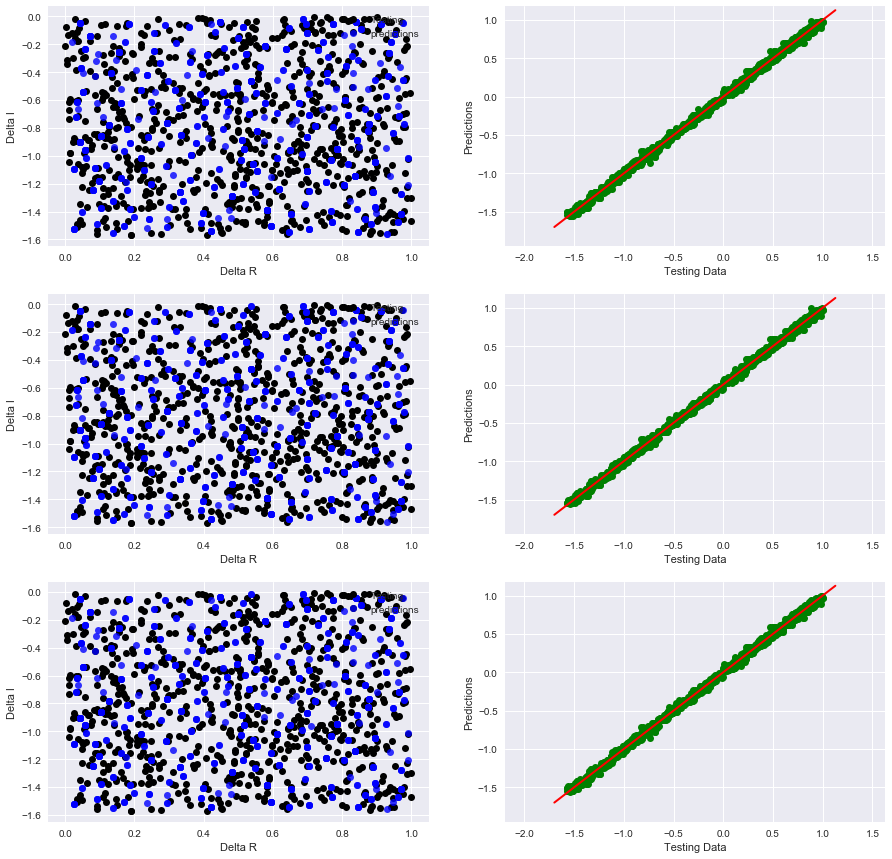

In [35]:
#Decision tree with different X features - average peak info
#Initialize the models
regr_1a = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
regr_2a = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
regr_3a = DecisionTreeRegressor(max_depth=30, min_samples_leaf=5)

#Fit the models
regr_1a.fit(X_new_train, Y_new_train)
regr_2a.fit(X_new_train, Y_new_train)
regr_3a.fit(X_new_train, Y_new_train)


#Print the coefficients or importances
#print('Regression 1a Feature Importance:', regr_1a.feature_importances_)
#print('Regression 2a Feature Importance:', regr_2a.feature_importances_)
#print('Regression 3a Feature Importance:', regr_3a.feature_importances_)

#Use model to predict
y_1a = regr_1a.predict(X_new_test)
y_2a = regr_2a.predict(X_new_test)
y_3a = regr_3a.predict(X_new_test)

from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
cross_val_score(regressor, X1, Y3, cv=10)

#### PLOTTING ####  
import pylab 
f,(ax) = plt.subplots(figsize=(15,15))
ax = pylab.subplot(321) 
myplot2(Y_new_test.iloc[:, 0], Y_new_test.iloc[:, 1], y_1a[:, 0], y_1a[:, 1])

ax = pylab.subplot(322) 
plotAgainst2(Y_new_test, y_1a)

ax = pylab.subplot(323) 
myplot2(Y_new_test.iloc[:, 0], Y_new_test.iloc[:, 1], y_2a[:, 0], y_2a[:, 1])

ax = pylab.subplot(324)  
plotAgainst2(Y_new_test, y_2a)

ax = pylab.subplot(325) 
myplot2(Y_new_test.iloc[:, 0], Y_new_test.iloc[:, 1], y_3a[:, 0], y_3a[:, 1])

ax = pylab.subplot(326) 
plotAgainst2(Y_new_test, y_3a)

##### Finding Residuals and R squared Score #####
print(' ')
myResiduals(Y_new_test['deltaR'], y_1a[:,1])
myRsquared(Y_new_test, y_1a, 1)
print(' ')
myResiduals(Y_new_test['deltaR'], y_2a[:,1])
myRsquared(Y_new_test, y_2a, 1)
print(' ')
myResiduals(Y_new_test['deltaR'], y_3a[:,1])
myRsquared(Y_new_test, y_3a, 1)

#Trying to understand the scoring
#print('Regression 1 Score: ', regr_1a.score(X_new_test,Y_new_test), ', using max depth of 10')
#print('Regression 2 Score: ', regr_2a.score(X_new_test,Y_new_test), ', using max depth of 20')
#print('Regression 3 Score: ', regr_3a.score(X_new_test,Y_new_test),', using max depth of 30')

#regressora = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
#print('Cross Validation Scores: ', cross_val_score(regressora, X_new_df, Y_new_df, cv=10))

The average residual for predict: 0.037
Residual is this percent of predict range 3.737 %
R squared Score: 0.9796
 
The average residual for predict: 0.0218
Residual is this percent of predict range 2.205 %
R squared Score: 0.9927
 
The average residual for predict: 0.0218
Residual is this percent of predict range 2.206 %
R squared Score: 0.9927


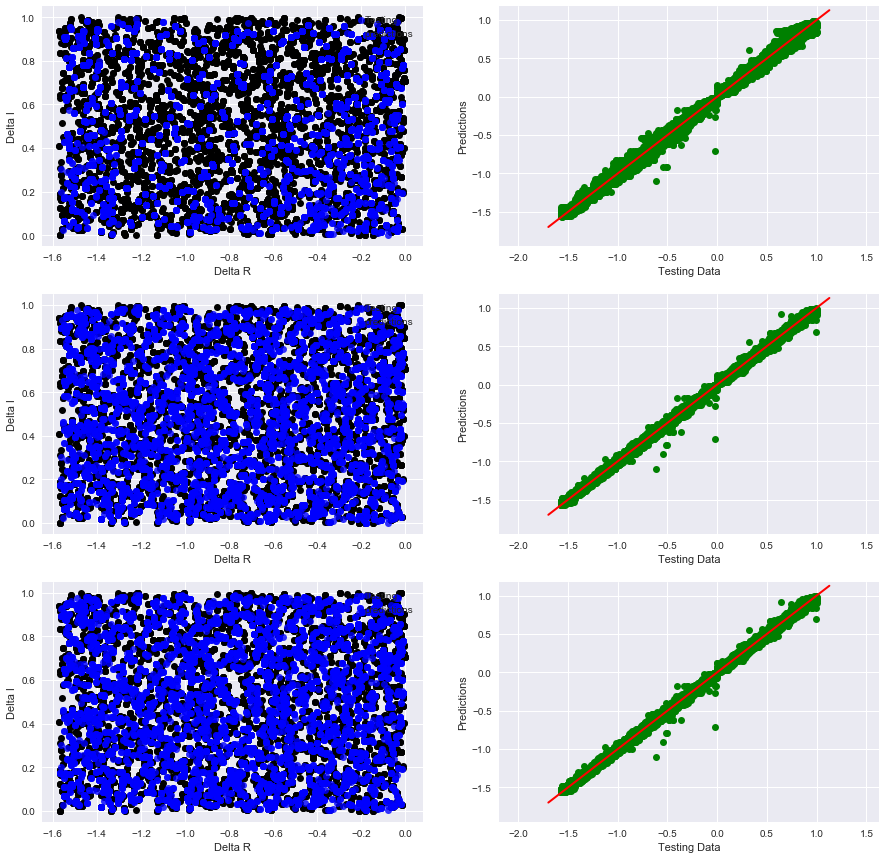

In [36]:
#Decision tree with different X features - no peak info (X2)
#Initialize the models
regr_1b = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
regr_2b = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
regr_3b = DecisionTreeRegressor(max_depth=30, min_samples_leaf=5)

#Fit the models
regr_1b.fit(X2_train, Y3_train)
regr_2b.fit(X2_train, Y3_train)
regr_3b.fit(X2_train, Y3_train)


#Print the coefficients or importances
#print('Regression 1b Feature Importance:', regr_1b.feature_importances_)
#print('Regression 2b Feature Importance:', regr_2b.feature_importances_)
#print('Regression 3b Feature Importance:', regr_3b.feature_importances_)

#Use model to predict
y_1b = regr_1b.predict(X2_test)
y_2b = regr_2b.predict(X2_test)
y_3b = regr_3b.predict(X2_test)

from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
cross_val_score(regressor, X1, Y3, cv=10)

#### PLOTTING ####    
import pylab
f,(ax) = plt.subplots(figsize=(15,15))
ax = pylab.subplot(321) 
myplot2(Y3_test.iloc[:, 0], Y3_test.iloc[:, 1], y_1b[:, 0], y_1b[:, 1])

ax = pylab.subplot(322) 
plotAgainst2(Y3_test, y_1b)

ax = pylab.subplot(323) 
myplot2(Y3_test.iloc[:, 0], Y3_test.iloc[:, 1], y_2b[:, 0], y_2b[:, 1])

ax = pylab.subplot(324)  
plotAgainst2(Y3_test, y_2b)

ax = pylab.subplot(325) 
myplot2(Y3_test.iloc[:, 0], Y3_test.iloc[:, 1], y_3b[:, 0], y_3b[:, 1])

ax = pylab.subplot(326) 
plotAgainst2(Y3_test, y_3b)

##### Finding Residuals and R Squared ######

myResiduals(Y3_test['deltaI'], y_1b[:,1])
myRsquared(Y3_test, y_1b, 1)
print(' ')
myResiduals(Y3_test['deltaI'], y_2b[:,1])
myRsquared(Y3_test, y_2b, 1)
print(' ')
myResiduals(Y3_test['deltaI'], y_3b[:,1])
myRsquared(Y3_test, y_3b, 1)

#Trying to understand the scoring
#print('Regression 1 Score: ', regr_1b.score(X2_test,Y3_test), ', using max depth of 10')
#print('Regression 2 Score: ', regr_2b.score(X2_test,Y3_test), ', using max depth of 20')
#print('Regression 3 Score: ', regr_3b.score(X2_test,Y3_test),', using max depth of 30')

#regressorb = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
#print('Cross Validation Scores: ', cross_val_score(regressorb, X2, Y3, cv=10))

 
The average residual for predict: 0.0866
Residual is this percent of predict range 8.757 %
R squared Score: 0.8227
 
The average residual for predict: 0.0909
Residual is this percent of predict range 9.183 %
R squared Score: 0.7828
 
The average residual for predict: 0.0909
Residual is this percent of predict range 9.184 %
R squared Score: 0.7826


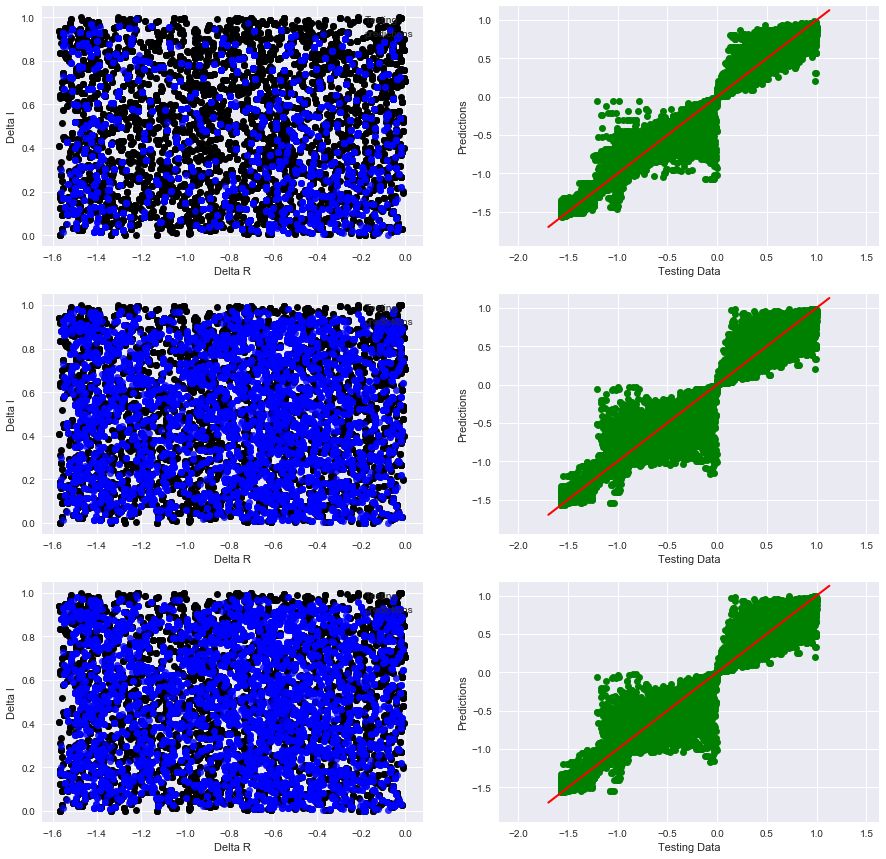

In [37]:
#Decision tree with different X features - just A, phi (X3)
#Initialize the models
regr_1c = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
regr_2c = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
regr_3c = DecisionTreeRegressor(max_depth=30, min_samples_leaf=5)

#Fit the models
regr_1c.fit(X3_train, Y3_train)
regr_2c.fit(X3_train, Y3_train)
regr_3c.fit(X3_train, Y3_train)


#Print the coefficients or importances
#print('Regression 1c Feature Importance:', regr_1c.feature_importances_)
#print('Regression 2c Feature Importance:', regr_2c.feature_importances_)
#print('Regression 3c Feature Importance:', regr_3c.feature_importances_)

#Use model to predict
y_1c = regr_1c.predict(X3_test)
y_2c = regr_2c.predict(X3_test)
y_3c = regr_3c.predict(X3_test)

from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
cross_val_score(regressor, X1, Y3, cv=10)

#### PLOTTING ####     
import pylab 
f,(ax) = plt.subplots(figsize=(15,15))
ax = pylab.subplot(321) 
myplot2(Y3_test.iloc[:, 0], Y3_test.iloc[:, 1], y_1c[:, 0], y_1c[:, 1])

ax = pylab.subplot(322) 
plotAgainst2(Y3_test, y_1c)

ax = pylab.subplot(323) 
myplot2(Y3_test.iloc[:, 0], Y3_test.iloc[:, 1], y_2c[:, 0], y_2c[:, 1])

ax = pylab.subplot(324)  
plotAgainst2(Y3_test, y_2c)

ax = pylab.subplot(325) 
myplot2(Y3_test.iloc[:, 0], Y3_test.iloc[:, 1], y_3c[:, 0], y_3c[:, 1])

ax = pylab.subplot(326) 
plotAgainst2(Y3_test, y_3c)

## Finding Residuals and R squared Score 
print(' ')
myResiduals(Y3_test['deltaI'], y_1c[:,1])
myRsquared(Y3_test, y_1c, 1)
print(' ')
myResiduals(Y3_test['deltaI'], y_2c[:,1])
myRsquared(Y3_test, y_2c, 1)
print(' ')
myResiduals(Y3_test['deltaI'], y_3c[:,1])
myRsquared(Y3_test, y_3c, 1)

#Trying to understand the scoring
#print('Regression 1c Score: ', regr_1c.score(X3_test,Y3_test), ', using max depth of 10')
#print('Regression 2c Score: ', regr_2c.score(X3_test,Y3_test), ', using max depth of 20')
#print('Regression 3c Score: ', regr_3c.score(X3_test,Y3_test),', using max depth of 30')

#regressorc = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
#print('Cross Validation Scores 3c: ', cross_val_score(regressorc, X3, Y3, cv=10))

In [38]:
#Visualize a Decision Tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(regr_1c, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X3_test.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_png(path = 'treeTest1.png')
Image(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'

# Random Forest

One way to improve the effectiveness of decision trees and reduce the risk of overfitting, is to implement a random forest, where there are several decision trees and certain nodes within are randomly removed to avoid having one node affect the results too much. Could also use bagging to avoid overfitting. 


From the scikit-learn page for RandomForestRegressor:
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [39]:
from sklearn.ensemble import RandomForestRegressor
rs = 42
regr_rf = RandomForestRegressor(max_depth = 5,  random_state=rs, n_estimators = 1)
regr_rf.fit(X1_train, Y3_train)

# print('Score: ', regr_rf.score(X1_test, Y3_test))
predict = pd.DataFrame(regr_rf.predict(X1_test), columns = ['deltaI', 'deltaR'])

The average residual for predict: 0.1214
Residual is this percent of predict range 7.815 %
R squared Score: 0.8062


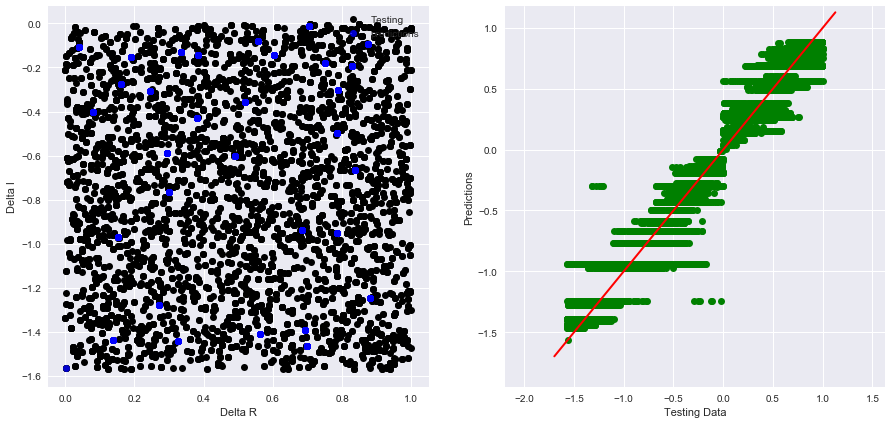

In [41]:
# pd.Series(regr_rf.feature_importances_, index= X1_train.columns)
# predict = pd.DataFrame(regr_rf.predict(X1_test), columns = ['deltaI', 'deltaR'])

#### PLOTTING #### 
import pylab 
f,(ax) = plt.subplots(figsize=(15,7))
ax = pylab.subplot(121) 
myplot2(Y2_test, Y1_test, predict['deltaR'], predict['deltaI'])

ax = pylab.subplot(122) 
plotAgainst2(Y3_test, predict)

#### RESIDUALS AND R SQUARED ####
myResiduals_index(Y1_test, predict['deltaI'])
myRsquared(Y3_test, predict, 1)




The average residual for predict: 0.0103
Residual is this percent of predict range 1.056 %
R squared Score: 0.9978


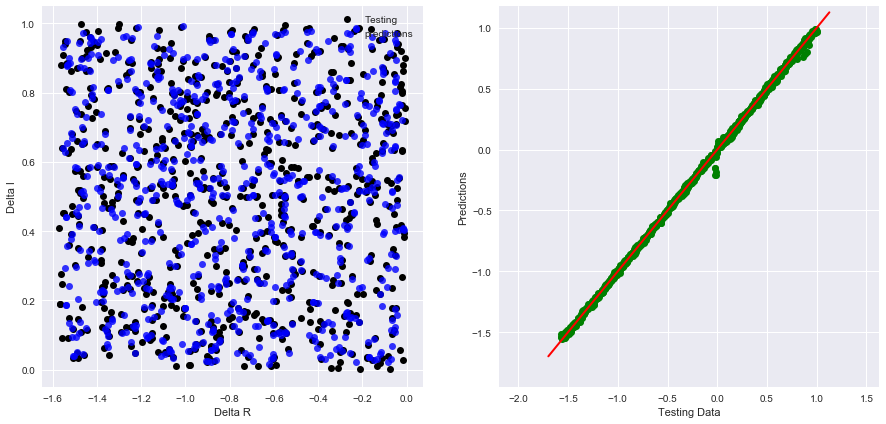

In [42]:
#Trying with a different dataset - average peak info

regr_rf1 = RandomForestRegressor(max_depth = 10, random_state = rs)
regr_rf1 = regr_rf1.fit(X_new_train, Y_new_train)
# print('Score: ', regr_rf1.score(X_new_test, Y_new_test)) #R^2 score 

predict1 = pd.DataFrame(regr_rf1.predict(X_new_test), columns = ['deltaI', 'deltaR'])

#### PLOTTING #### 
import pylab 
f,(ax) = plt.subplots(figsize=(15,7))
ax = pylab.subplot(121) 
myplot2(Y_new_test['deltaR'], Y_new_test['deltaI'], predict1['deltaR'], predict1['deltaI'])

ax = pylab.subplot(122) 
plotAgainst2(Y_new_test, predict1)

## Find Residuals and R squared Score 
myResiduals(Y_new_test['deltaI'], predict1['deltaI'])
myRsquared(Y_new_test, predict1, 1)


In [43]:
#pd.Series(regr_rf1.feature_importances_, index= X_new_train.columns)


In [44]:
#Save images of each decision tree in the forest
#import six
#from sklearn import tree

#dotfile = six.StringIO()
#i_tree = 0
#for tree_in_forest in regr_rf1.estimators_:
   # if (i_tree <= len(regr_rf1.estimators_)):        
      #  export_graphviz(tree_in_forest, out_file=dotfile, feature_names=X_new_train.columns)
       # (pydotplus.graph_from_dot_data(dotfile.getvalue())).write_png('dtree_depth6_'+ str(i_tree) +'.png')
        #dotfile = six.StringIO()
        #i_tree = i_tree + 1

The average residual for predict: 0.0217
Residual is this percent of predict range 1.401 %
R squared Score: 0.9929


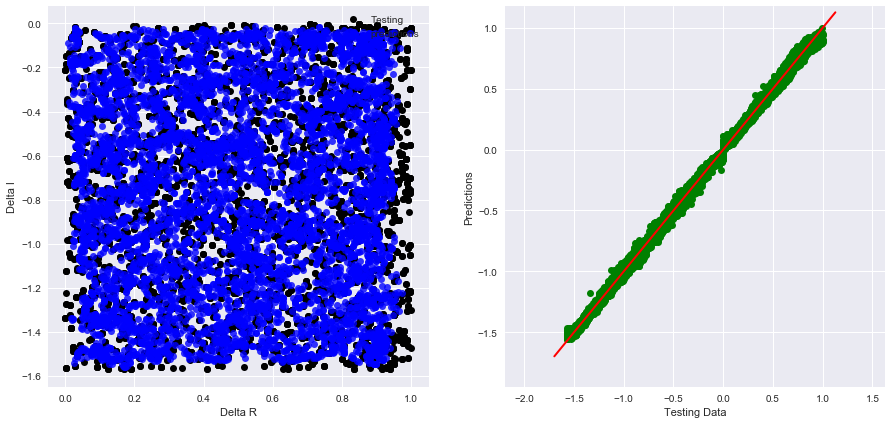

In [45]:
regr_rf2 = RandomForestRegressor(max_depth = 10,  random_state=rs)
regr_rf2.fit(X2_train, Y3_train)
pd.Series(regr_rf2.feature_importances_, index= X2_train.columns)
predict2 = pd.DataFrame(regr_rf2.predict(X2_test), columns = ['deltaI', 'deltaR'])

import pylab 
f,(ax) = plt.subplots(figsize=(15,7))
ax = pylab.subplot(121) 
myplot2(Y2_test, Y1_test, predict2['deltaR'], predict2['deltaI'])

ax = pylab.subplot(122) 
plotAgainst2(Y3_test, predict2)

#### RESIDUALS AND R SQUARED ####
myResiduals_index(Y1_test, predict2['deltaI'])
myRsquared(Y3_test, predict2, 1)

The average residual for predict: 0.1171
Residual is this percent of predict range 7.594 %
R squared Score: 0.8413


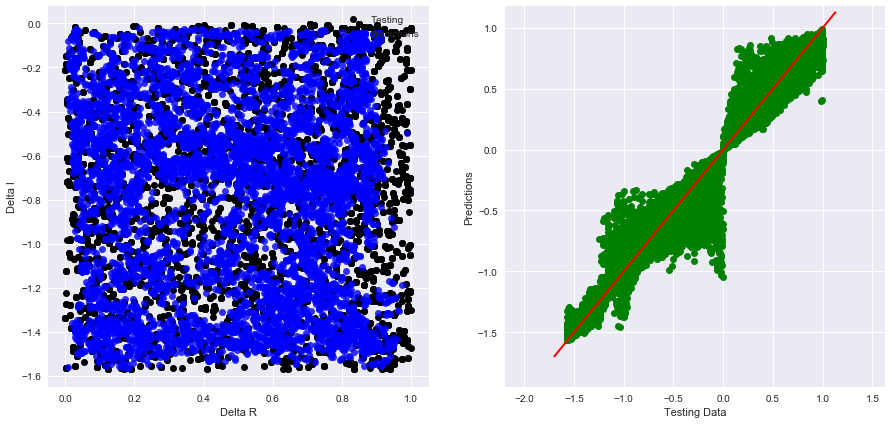

In [46]:
regr_rf3 = RandomForestRegressor(max_depth = 10,  random_state=rs, n_estimators= 25)
regr_rf3.fit(X3_train, Y3_train)
pd.Series(regr_rf3.feature_importances_, index= X3_train.columns)
predict3 = pd.DataFrame(regr_rf3.predict(X3_test), columns = ['deltaI', 'deltaR'])

import pylab 
f,(ax) = plt.subplots(figsize=(15,7))
ax = pylab.subplot(121) 
myplot2(Y2_test, Y1_test, predict3['deltaR'], predict3['deltaI'])

ax = pylab.subplot(122) 
plotAgainst2(Y3_test, predict3)

#### RESIDUALS AND R SQUARED ####
myResiduals_index(Y1_test, predict3['deltaI'])
myRsquared(Y3_test, predict3, 1)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
#####################
from sklearn.ensemble import RandomForestRegressor
rs = 42
min_trees = 1
max_trees = 20
tree_range = max_trees - min_trees
min_depth = 5
max_depth = 20
depth_range = max_depth - min_depth 
myRsquared_list = []
depth_list = []
width_list = []
for n_estimator in range (min_trees, max_trees):
    for maxDepth in range (min_depth, max_depth):
        regr_rf = RandomForestRegressor(max_depth = maxDepth,  random_state=rs, n_estimators = n_estimator)
        maxDepth = maxDepth
        n_estimator = n_estimator
        regr_rf.fit(X1_train, Y3_train)
        predict = pd.DataFrame(regr_rf.predict(X1_test), columns = ['deltaI', 'deltaR'])
        myRsquared = r2_score(Y3_test,predict)
        myRsquared_list = np.append(myRsquared_list, [myRsquared])
depth_list = np.linspace(min_depth, max_depth, depth_range)
width_list = np.linspace(min_trees, max_trees, tree_range)
myRsquared_list = np.reshape(myRsquared_list, (len(width_list), len(depth_list)))
###########

In [ ]:
X, Y = np.meshgrid(depth_list, width_list)
myRsquared_list = np.flipud(myRsquared_list)
Z = myRsquared_list 

#Plot the surface.
plt.imshow(Z, cmap=cm.jet, extent =[min_depth, max_depth, max_trees, min_trees], interpolation = 'None', aspect = 'auto')
plt.xlabel('Depth')
plt.ylabel('Trees')
plt.show()